<a href="https://colab.research.google.com/github/2AMissinou/Metabolomics-Filtering/blob/main/Metabolic_Features_Filtering_v1_5_rp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='	dodgerblue'> Metabolic features Clean up and Multivariate analysis **<font>

---

Authors: Anani Amegan Missinou (anani.a.missinou@gmail.com) <br>
Input file format: .csv files or .txt files <br>
Outputs: .csv files  <br>
Dependencies: ggplot2, dplyr, ecodist, vegan, svglite\

## Use R and Python code Run rmagic by executing this command %load_ext rpy2. ipython.


1.   Start rmagic by executing this in a cell: %load_ext rpy2. ipython. 
2.   Use %%R to execute cell magic. After that, every time you want to use R, add %%R in the beginning of each cell before code running.

In [ ]:
#installing and calling the necessary packages:
install.packages("ggplot2")
install.packages("dplyr")
install.packages("ecodist") #for PCoA using Bray Curtis distance
install.packages("vegan") #for PermANOVA
install.packages("svglite") # for saving ggplots as svg files

In [6]:
require("ggplot2")
require("dplyr")
require("ecodist")
require("vegan")
require("svglite")

## Setting a local working directory and creating an automatic result directory:
Works well with Jupyter Notebook. If you are working with Jupyter Notebook, you can simply copy the folder path from your local computer to the next cell output line. It will be set as your working directory <br> 
For ex: D:\User\Project\Test_Data <br>
<br>
For Google Collab, we can upload the necessary files into a new folder using the 'Files' icon on the left and set the folder as working directory. And all the ouput files will be saved here as well and you need to download them finally into your local computer

In [7]:
# setting the current directory as the working directory
Directory <- normalizePath(readline("Enter the path of the folder with input files: "),"/",mustWork=FALSE)
setwd(Directory)

Enter the path of the folder with input files: .


In [8]:
getwd()

[1] "/content"

In [ ]:
# Getting all the files in the folder
dirs <- dir(path=paste(getwd(), sep=""), full.names=TRUE, recursive=TRUE)
folders <- unique(dirname(dirs))
files <- list.files(folders, full.names=TRUE)
files_1 <- basename((files))
files_2 <- dirname((files))
# Creating a Result folder
dir.create(path=paste(files_2[[1]], "_Results", sep=""), showWarnings = TRUE)
fName <-paste(files_2[[1]], "_Results", sep="")

print(files_1)

[1] "anscombe.json"                "california_housing_test.csv" 
[3] "california_housing_train.csv" "mnist_test.csv"              
[5] "mnist_train_small.csv"        "README.md"                   


**<font color='red'> In the following line, enter the required file ID numbers separated by commas. For example as: 1,2,3 </font>**

In [ ]:
input <- as.double(unlist(strsplit(readline("Specify the file index of gapfilled & non-gapfilled feature-file, metadata:"), split=",")))

#Gets the extension of each file. Ex:csv
pattern <- c()
for (i in files_1){
  sep_file <- substr(i, nchar(i)-2,nchar(i))
  pattern <- rbind(pattern,sep_file)
}
#pattern

ft <- read.csv(files_1[input[1]],sep = ifelse(pattern[input[1]]!="csv","\t",","), header=TRUE,check.names = FALSE) # By applying 'row.names = 1', the 1st column 'ID' becomes the row names
nft<- read.csv(files_1[input[2]],sep=ifelse(pattern[input[2]]!="csv","\t",","), header = TRUE,check.names = FALSE)
md <-read.csv(files_1[input[3]], sep = ifelse(pattern[input[3]]!="csv","\t",","), header=TRUE,check.names = FALSE)

## Reading the input data using URL (from Github):
Alternatively, we can also directly pull the data files from our Functional Metabolomics Github page:

In [9]:
## Non-gap filled
nft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/CMFI_Seminar_Multivariate_Statistics/main/Test_Data/20220716_Xenobiotic_metabolism_non_gapfilled_quant_Bsub_quant.csv'
## Gap filled
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/CMFI_Seminar_Multivariate_Statistics/main/Test_Data/20220716_Xenobiotic_metabolism_gapfilled_quant_Bsub.csv'
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/CMFI_Seminar_Multivariate_Statistics/main/Test_Data/20220716_Xenobiotic_Metabolism_metadata_Bsub.txt'

In [10]:
nft <- read.csv(nft_url, header = T, check.names = F)
ft <- read.csv(ft_url, header = T, check.names = F)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

Lets check if the data has been read correclty!!

In [11]:
head(ft)
dim(ft)

,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,⋯,t6_BS_2.mzML Peak area,t5_BS_1.mzML Peak area,t6_BS_3.mzML Peak area,t0_BS_1.mzML Peak area,t9_BS_1.mzML Peak area,t5_BS_2.mzML Peak area,t8_BS_3.mzML Peak area,t9_BS_3.mzML Peak area,t9_BS_2.mzML Peak area,
,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,2,284.0490,0.06921104,NA,NA,NA,NA,NA,NA,NA,⋯,23021.77,18208.166,19423.74,17433.18,25643.275,19439.27,28515.10,27789.33,24276.26,NA
2,8,281.0509,0.10351847,NA,NA,NA,NA,NA,NA,NA,⋯,1725159.00,1687922.400,1711116.90,1525560.80,1988580.500,1680300.80,2050065.20,1969012.20,1937270.80,NA
3,10,267.0352,0.12503392,NA,NA,NA,NA,NA,NA,NA,⋯,127510.91,8224.141,123302.27,83531.95,166977.810,117669.37,155001.64,159289.83,155360.70,NA
4,13,227.0220,0.03547234,NA,NA,NA,NA,NA,NA,NA,⋯,43124.89,21728.576,28306.74,21987.09,77407.750,52930.57,41270.76,74911.14,40599.87,NA
5,14,239.0947,0.03455123,NA,NA,NA,NA,NA,NA,NA,⋯,89629.49,89971.610,69065.44,92206.42,8322.643,89443.13,85359.16,53224.13,98724.91,NA
6,16,302.0587,0.04110153,NA,NA,NA,NA,NA,NA,NA,⋯,38676.01,79390.100,34950.79,66040.79,65106.055,23823.50,50425.25,37610.27,85097.12,NA


[1] 5807   56

In [12]:
head(nft)
dim(nft)

,row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,⋯,t6_BS_2.mzML Peak area,t5_BS_1.mzML Peak area,t6_BS_3.mzML Peak area,t0_BS_1.mzML Peak area,t9_BS_1.mzML Peak area,t5_BS_2.mzML Peak area,t8_BS_3.mzML Peak area,t9_BS_3.mzML Peak area,t9_BS_2.mzML Peak area,
,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,2,284.0490,0.00635683,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,0,NA
2,8,281.0508,0.06924535,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,0,NA
3,10,267.0351,0.09624655,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,0,NA
4,13,227.0220,0.11498167,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,0,NA
5,14,239.0947,0.11623713,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,0,NA
6,16,302.0586,0.12748633,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,0,NA


[1] 5807   56

In [13]:
head(md)
dim(md)

,filename,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>
1,t0_BS_C.mzML Peak area,B.subtilis,Without_Treatment,0,-0.1666667,-10,0
2,t0_BS_1.mzML Peak area,B.subtilis,Without_Treatment,0,-0.1666667,-10,1
3,t0_BS_2.mzML Peak area,B.subtilis,Without_Treatment,0,-0.1666667,-10,2
4,t0_BS_3.mzML Peak area,B.subtilis,Without_Treatment,0,-0.1666667,-10,3
5,t1_BS_C.mzML Peak area,B.subtilis,Without_Treatment,1,0.0000000,0,0
6,t1_BS_1.mzML Peak area,B.subtilis,With_Treatment,1,0.0000000,0,1


[1] 42  7

Trying to bring the feature table and metadata in the correct format such as the rownames of metadata and column names of feature table are the same. They both are the file names and they need to be same as from now on, we will call the columns in our feature table based on our metadata information. Thus, using the metadata, the user can filter their data easily. You can also directly deal with your feature table without metadata by getting your hands dirty with some coding!! But having a metadata improves the user-experience greatly.

In [14]:
#Removing Peak area extensions
colnames(ft) <- gsub(' Peak area','',colnames(ft))
colnames(nft) <- gsub(' Peak area','',colnames(nft))
md$filename<- gsub(' Peak area','',md$filename)

#Removing if any NA columns present in the md file
ft <- ft[,colSums(is.na(ft))<nrow(ft)]
nft <- nft[,colSums(is.na(nft))<nrow(nft)]
md <- md[,colSums(is.na(md))<nrow(md)]

#Changing the row names of the files
rownames(md) <- md$filename
md <- md[,-1]
rownames(ft) <- paste(ft$'row ID',round(ft$'row m/z',digits = 3),round(ft$'row retention time',digits = 3), sep = '_')
rownames(nft) <- paste(nft$'row ID',round(nft$'row m/z',digits = 3),round(nft$'row retention time',digits = 3), sep = '_')

#Picking only the files with column names containing 'mzML'
ft <- ft[,grep('mzML',colnames(ft))]
nft <- nft[,grep('mzML',colnames(nft))]

# Converting replicate attributes into factors (categorical data)
md$ATTRIBUTE_replicates <- as.factor(md$ATTRIBUTE_replicates)

Lets check the files once again!!

In [15]:
head(nft)
dim(nft)

,Blank_B.mzML,t2_BS_C.mzML,t0_BS_C.mzML,Blank_A.mzML,t1_BS_C.mzML,t5_BS_C.mzML,t3_BS_3.mzML,t2_BS_2.mzML,t3_BS_C.mzML,t2_BS_1.mzML,⋯,t5_BS_3.mzML,t6_BS_2.mzML,t5_BS_1.mzML,t6_BS_3.mzML,t0_BS_1.mzML,t9_BS_1.mzML,t5_BS_2.mzML,t8_BS_3.mzML,t9_BS_3.mzML,t9_BS_2.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2_284.049_0.006,0,0,0,24335.37,0,0,65528.32,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
8_281.051_0.069,0,0,0,1604372.00,0,0,0.00,0,0,3636798,⋯,0,0,0,0,0,0,0,0,0,0
10_267.035_0.096,0,0,0,90303.77,0,0,0.00,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
13_227.022_0.115,0,0,0,37453.91,0,0,0.00,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
14_239.095_0.116,0,0,0,72088.13,0,0,0.00,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
16_302.059_0.127,0,0,0,45895.42,0,0,0.00,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 5807   42

In [16]:
head(ft)
dim(ft)

,Blank_B.mzML,t2_BS_C.mzML,t0_BS_C.mzML,Blank_A.mzML,t1_BS_C.mzML,t5_BS_C.mzML,t3_BS_3.mzML,t2_BS_2.mzML,t3_BS_C.mzML,t2_BS_1.mzML,⋯,t5_BS_3.mzML,t6_BS_2.mzML,t5_BS_1.mzML,t6_BS_3.mzML,t0_BS_1.mzML,t9_BS_1.mzML,t5_BS_2.mzML,t8_BS_3.mzML,t9_BS_3.mzML,t9_BS_2.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2_284.049_0.069,18021.57,16982.87,20755.18,24335.37,19328.70,23160.66,65528.32,4663.611,22136.30,4262.391,⋯,21375.27,23021.77,18208.166,19423.74,17433.18,25643.275,19439.27,28515.10,27789.33,24276.26
8_281.051_0.104,1402257.60,1537228.20,228957.92,1604372.00,1559159.10,263653.38,266014.78,238900.690,1652363.80,3636798.200,⋯,1716907.50,1725159.00,1687922.400,1711116.90,1525560.80,1988580.500,1680300.80,2050065.20,1969012.20,1937270.80
10_267.035_0.125,83519.48,96762.88,84678.31,90303.77,81488.60,115550.96,107415.57,82006.620,12551.38,96853.070,⋯,122031.09,127510.91,8224.141,123302.27,83531.95,166977.810,117669.37,155001.64,159289.83,155360.70
13_227.022_0.035,21758.15,26107.27,29125.81,37453.91,20693.07,64607.33,34512.42,27379.434,62945.52,32709.602,⋯,63844.68,43124.89,21728.576,28306.74,21987.09,77407.750,52930.57,41270.76,74911.14,40599.87
14_239.095_0.035,94997.12,53176.10,100849.48,72088.13,95871.80,90154.41,91077.77,41458.566,89611.88,89120.625,⋯,90778.20,89629.49,89971.610,69065.44,92206.42,8322.643,89443.13,85359.16,53224.13,98724.91
16_302.059_0.041,27851.37,48689.27,51742.97,45895.42,32060.05,59807.74,29840.88,69905.130,75531.13,35575.457,⋯,72733.80,38676.01,79390.100,34950.79,66040.79,65106.055,23823.50,50425.25,37610.27,85097.12


[1] 5807   42

In [17]:
head(md)
dim(md)

,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<int>,<dbl>,<int>,<fct>
t0_BS_C.mzML,B.subtilis,Without_Treatment,0,-0.1666667,-10,0
t0_BS_1.mzML,B.subtilis,Without_Treatment,0,-0.1666667,-10,1
t0_BS_2.mzML,B.subtilis,Without_Treatment,0,-0.1666667,-10,2
t0_BS_3.mzML,B.subtilis,Without_Treatment,0,-0.1666667,-10,3
t1_BS_C.mzML,B.subtilis,Without_Treatment,1,0.0000000,0,0
t1_BS_1.mzML,B.subtilis,With_Treatment,1,0.0000000,0,1


[1] 42  6

**About the experiment:**
- Bacteria (B.subtilis) was treated with a pool of antibiotics (Sulfamethoxazole, sulfadimethoxine, cyproconazole) including a herbicide Asulam, taken at a concentration lower than their MIC (minimum inhibitory concentration).
- The samples were collected at different timepoints, the compounds were extracted (with 50% EtOAc) and measured using LC-MS/MS.
- The goal of the experiment was to look for any potential biotransformation. eg: Drug or xenobiotic metabolism

## Splitting the data into Control and Samples using Metadata:

In [18]:
input_data <- ft

In [19]:
head(md)
print(matrix(data=colnames(md),nrow=length(colnames(md))))

#These lines are not needed in R console, but in Jupyter Notebook to get the previous print statement working
flush.console()  
Sys.sleep(0.2)

Condition <- as.double(unlist(readline("Enter the index of the attribute to split sample and control:")))

flush.console()  
Sys.sleep(0.2)

Levels_Cdtn <- levels(as.factor(md[,Condition[1]]))
print(matrix(Levels_Cdtn,length(Levels_Cdtn)))

flush.console()  
Sys.sleep(0.2)
    
#Among the shown levels of an attribute, select the ones to keep
Ctrl_id <- as.double(unlist(readline("Enter the index of your BLANK:")))
paste0('You chosen blank is:',Levels_Cdtn[Ctrl_id])

#Splitting the data into control and samples based on the metadata
md_Ctrl <- md[(md[,Condition] == Levels_Cdtn[Ctrl_id]),]
Ctrl <- input_data[,which(colnames(input_data)%in%rownames(md_Ctrl))] 
md_Samples <- md[(md[,Condition] != Levels_Cdtn[Ctrl_id]),]
Samples <- input_data[,which(colnames(input_data)%in%rownames(md_Samples))] 

,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<int>,<dbl>,<int>,<fct>
t0_BS_C.mzML,B.subtilis,Without_Treatment,0,-0.1666667,-10,0
t0_BS_1.mzML,B.subtilis,Without_Treatment,0,-0.1666667,-10,1
t0_BS_2.mzML,B.subtilis,Without_Treatment,0,-0.1666667,-10,2
t0_BS_3.mzML,B.subtilis,Without_Treatment,0,-0.1666667,-10,3
t1_BS_C.mzML,B.subtilis,Without_Treatment,1,0.0000000,0,0
t1_BS_1.mzML,B.subtilis,With_Treatment,1,0.0000000,0,1


     [,1]                  
[1,] "ATTRIBUTE_species"   
[2,] "ATTRIBUTE_SampleType"
[3,] "ATTRIBUTE_timepoint" 
[4,] "ATTRIBUTE_hours"     
[5,] "ATTRIBUTE_mins"      
[6,] "ATTRIBUTE_replicates"
Enter the index of the attribute to split sample and control:2
     [,1]               
[1,] "Blank"            
[2,] "With_Treatment"   
[3,] "Without_Treatment"
Enter the index of your BLANK:1


[1] "You chosen blank is:Blank"

In [20]:
head(Ctrl)
dim(Ctrl)

,Blank_B.mzML,Blank_A.mzML
,<dbl>,<dbl>
2_284.049_0.069,18021.57,24335.37
8_281.051_0.104,1402257.60,1604372.00
10_267.035_0.125,83519.48,90303.77
13_227.022_0.035,21758.15,37453.91
14_239.095_0.035,94997.12,72088.13
16_302.059_0.041,27851.37,45895.42


[1] 5807    2

In [24]:
head(Samples)
dim(Samples)

,t2_BS_C.mzML,t0_BS_C.mzML,t1_BS_C.mzML,t5_BS_C.mzML,t3_BS_3.mzML,t2_BS_2.mzML,t3_BS_C.mzML,t2_BS_1.mzML,t3_BS_2.mzML,t1_BS_1.mzML,⋯,t5_BS_3.mzML,t6_BS_2.mzML,t5_BS_1.mzML,t6_BS_3.mzML,t0_BS_1.mzML,t9_BS_1.mzML,t5_BS_2.mzML,t8_BS_3.mzML,t9_BS_3.mzML,t9_BS_2.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2_284.049_0.069,16982.87,20755.18,19328.70,23160.66,65528.32,4663.611,22136.30,4262.391,4854.831,20930.33,⋯,21375.27,23021.77,18208.166,19423.74,17433.18,25643.275,19439.27,28515.10,27789.33,24276.26
8_281.051_0.104,1537228.20,228957.92,1559159.10,263653.38,266014.78,238900.690,1652363.80,3636798.200,1617942.000,1455835.20,⋯,1716907.50,1725159.00,1687922.400,1711116.90,1525560.80,1988580.500,1680300.80,2050065.20,1969012.20,1937270.80
10_267.035_0.125,96762.88,84678.31,81488.60,115550.96,107415.57,82006.620,12551.38,96853.070,103621.760,86706.23,⋯,122031.09,127510.91,8224.141,123302.27,83531.95,166977.810,117669.37,155001.64,159289.83,155360.70
13_227.022_0.035,26107.27,29125.81,20693.07,64607.33,34512.42,27379.434,62945.52,32709.602,20306.172,18615.79,⋯,63844.68,43124.89,21728.576,28306.74,21987.09,77407.750,52930.57,41270.76,74911.14,40599.87
14_239.095_0.035,53176.10,100849.48,95871.80,90154.41,91077.77,41458.566,89611.88,89120.625,90527.450,43122.74,⋯,90778.20,89629.49,89971.610,69065.44,92206.42,8322.643,89443.13,85359.16,53224.13,98724.91
16_302.059_0.041,48689.27,51742.97,32060.05,59807.74,29840.88,69905.130,75531.13,35575.457,75338.790,60733.66,⋯,72733.80,38676.01,79390.100,34950.79,66040.79,65106.055,23823.50,50425.25,37610.27,85097.12


[1] 5807   40

### Creating a function named FrequencyPlot:  
The below function takes in the two input datatables: for example, gapfilled and non-gapfilled, calculates the frequency distribution of the data in the order of 10 and produces a grouped barplot showing the distribution as output. The frequency plot shows where the features are present in higher number.

In [26]:
#'Global' settings for plot size in the output cell
options(repr.plot.width=10, repr.plot.height=8,res=600) #For google collab
#options(repr.plot.width=5, repr.plot.height=3) #For Jupyter Notebook

In [27]:
FrequencyPlot <- function(x1,x2){
  
   #creating bins from -1 to 10^10 using sequence function seq()
    bins <- c(-1,0,(1 * 10^(seq(0,10,1)))) 
    
    #cut function cuts the give table into its appropriate bins
    scores_x1 <- cut(as.matrix(x1),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10')) 
    
    #transform function convert the tables into a column format: easy for visualization 
    Table_x1<-transform(table(scores_x1)) #contains 2 columns: "scores_x1", "Freq"
    
    #Repeating the same steps for x2
    scores_x2 <- cut(as.matrix(x2),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10'))
    Table_x2<-transform(table(scores_x2))
  
    #Getting the names of x1 and x2
    arg1 <- deparse(substitute(x1))
    arg2 <-deparse(substitute(x2))
    
    #Creating a data frame for plotting
    data_plot <- as.data.frame(c(Table_x1$Freq,Table_x2$Freq)) #Concatenating the frequency info of both tables rowwise
    colnames(data_plot) <- "Freq" #naming the 1st column as 'Freq'
    data_plot$Condition <- c(rep(arg1,12),rep(arg2,12)) #adding a 2nd column 'Condition', which just repeats the name of x1 and x2 accordingly
    data_plot$Range_bins <- rep(Table_x1$scores_x1,2) #Adding 3rd column 'Range Bins'
    data_plot$Log_Freq <- log(data_plot$Freq+1) #Log scaling the frequency values
    
    ## GGPLOT2
    BarPlot <- ggplot(data_plot, aes(Range_bins, Log_Freq, fill = Condition)) + 
    geom_bar(stat="identity", position = "dodge", width=0.4) + 
    scale_fill_brewer(palette = "Set1") +
    ggtitle(label="Frequency plot") +
    xlab("Range") + ylab("(Log)Frequency") + labs(fill = "Data Type") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +   # setting the angle for the x label
    theme(axis.text.y = element_text(angle = 45, vjust = 0.5, hjust=1)) +   # setting the angle for the y label
    theme(plot.title = element_text(hjust = 0.5)) # centering the plot title
  
    print(BarPlot)
}  

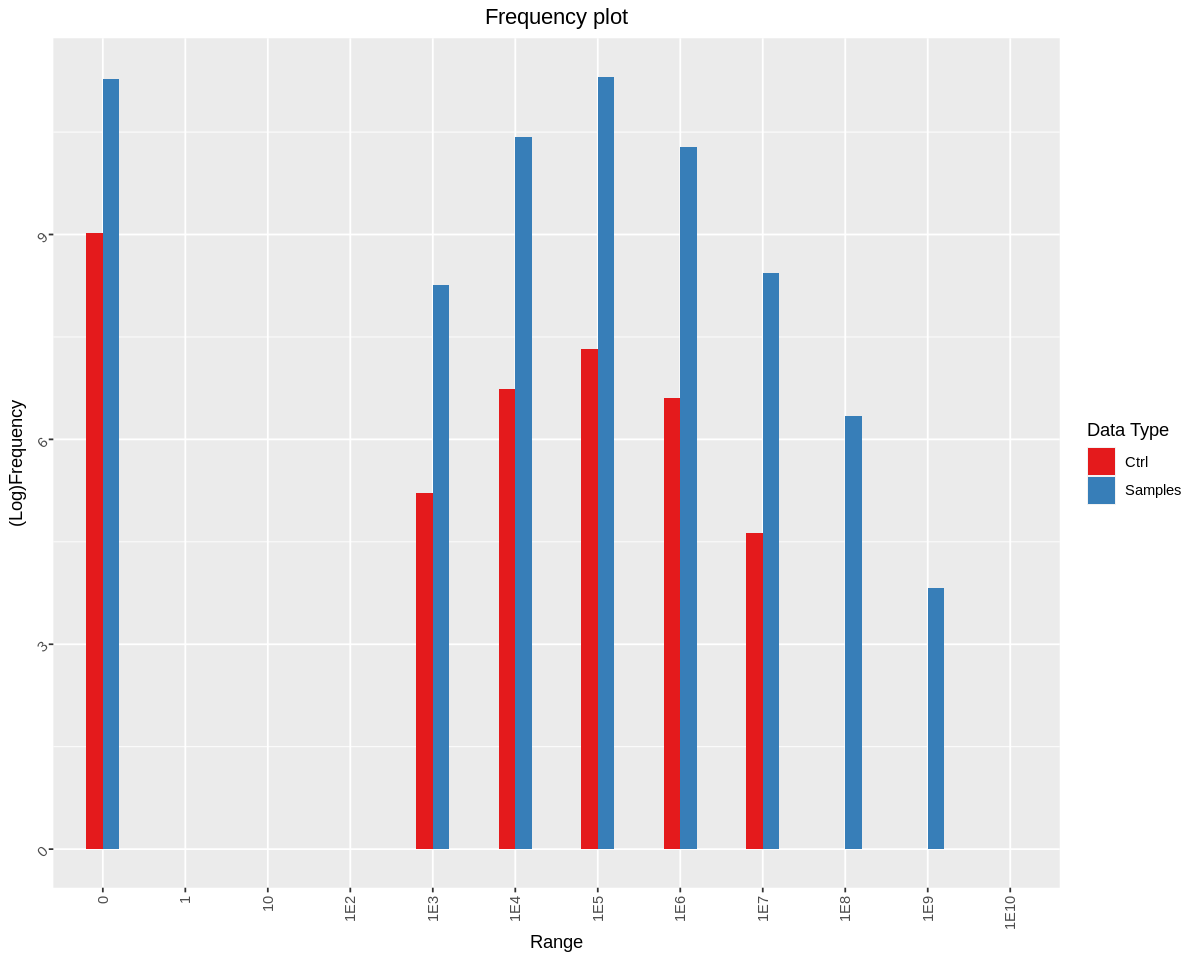

In [28]:
FrequencyPlot(Samples, Ctrl )

## Blank Removal:

(Note: In LC-MS/MS, we use solvents also called as Blanks which are usually injected time-to-time to prevent carryover of the sample) </br>

For the Blank removal step, we need to split the data as control blanks and samples. </br>

**The blanks we are referring to here, is the control blanks in the experiment and not the LC-MS/MS blanks.**
- The control blanks here is the sample without treatment. 
- Samples are biological replicates with treatment and we have two sets of data: B.sub and E.coli. </br>

In general, having multiple control blanks helps us to compare any variation in the data. Comparing control to the sample helps us to identify the background features that contribute to any technical variation. A common filtering method is to use a cutoff to remove features that are not present sufficient enough in our biological samples.

1. We find an average for all the feature intensities in your control set and sample set.
Therefore, for n no.of features in a control or sample set, we get n no.of averaged features.
2. Next, we get a ratio of this average_control vs average_sample. This ratio Control/sample tells us how much of that particular feature of a sample gets its contribution from control. If it is more than 30% (or Cutoff as 0.3), we consider the feature as noise.
3. The resultant information (if ratio > Cutoff or not) is stored in a bin such as **1 == Noise or background signal, 0 == Feature Signal**
4. We count the no.of features in the bin that satisfies the condition ratio > cutoff, and consider those features as 'noise or background features' and remove them.

For a dataset containing several batches, the filtering steps are performed batch-wise.

In [29]:
if(readline('Do you want to perform Blank Removal- Y/N:')=='Y'){
    
    #When cutoff is low, more noise (or background) detected; With higher cutoff, less background detected, thus more features observed
    Cutoff <- as.numeric(readline('Enter Cutoff value between 0.1 & 1:')) # (i.e. 10% - 100%). Ideal cutoff range: 0.1-0.3
    
    #Getting mean for every feature in Ctrl and Samples
    Avg_ctrl <- rowMeans(Ctrl, na.rm= FALSE, dims = 1) # set na.rm = FALSE to check if there are NA values. When set as TRUE, NA values are changed to 0
    Avg_samples <- rowMeans(Samples, na.rm= FALSE, dims = 1)
    
    #Getting the ratio of Ctrl vs Sample
    Ratio_Ctrl_Sample <- (Avg_ctrl+1)/(Avg_samples+1)
    
    # Creating a bin with 1s when the ratio>Cutoff, else put 0s
    Bg_bin <- ifelse(Ratio_Ctrl_Sample > Cutoff, 1, 0 )
    Blank_removal <- cbind(Samples,Bg_bin)

    # Checking if there are any NA values present. Having NA values in the 4 variables will affect the final dataset to be created
    temp_NA_Count <-cbind(Avg_ctrl ,Avg_samples,Ratio_Ctrl_Sample,Bg_bin)
    
    print('No of NA values in the following columns:')
    print(colSums(is.na(temp_NA_Count)))

     #Calculating the number of background features and features present
    print(paste("No.of Background or noise features:",sum(Bg_bin ==1,na.rm = TRUE)))
    print(paste("No.of features after excluding noise:",(nrow(Samples) - sum(Bg_bin ==1,na.rm = TRUE)))) 

    Blank_removal <- Blank_removal %>% filter(Bg_bin == 0) # Taking only the feature signals
    Blank_removal <- as.matrix(Blank_removal[,-ncol(Blank_removal)]) # removing the last column Bg_bin 
}

Do you want to perform Blank Removal- Y/N:Y
Enter Cutoff value between 0.1 & 1:0.3
[1] "No of NA values in the following columns:"
         Avg_ctrl       Avg_samples Ratio_Ctrl_Sample            Bg_bin 
                0                 0                 0                 0 
[1] "No.of Background or noise features: 1311"
[1] "No.of features after excluding noise: 4496"


In [30]:
dim(Blank_removal)

[1] 4496   40

## Imputation: 

For several reasons, real world datasets might have some missing values in it, in the form of NA, NANs or 0s. Eventhough the gapfilling step of MZmine fills the missing values, we still end up with some missing values or 0s in our feature table. This could be problematic for statistical analysis. 
In order to have a better dataset, we cannot simply discard those rows or columns with missing values as we will lose a chunk of our valuable data.
Instead we can try imputing those missing values. Imputation involves replacing the missing values in the data with a meaningful, reasonable guess. There are several methods, such as:  
1) Mean imputation (replacing the missing values in a column with the mean or average of the column)  
2) Replacing it with the most frequent value  
3) Several other machine learning imputation methods such as k-nearest neighbors algorithm(k-NN), Hidden Markov Model(HMM)

One such method, we are going to use is: **to replace the zeros from the gapfilled quant table with the non-gap filled table** we get from MZmine. In order to do that, we can visualize our data distribution using the frequenct plot

In [31]:
GapFilled <-Blank_removal
NotGapFilled <- nft

Do you want to perform Imputation with minimum value of NonGapFilled table? - Y/N:Y
[1] "The minimum value greater than 0 for GapFilled:123"
[1] "The minimum value greater than 0 for NotGapFilled:3766"


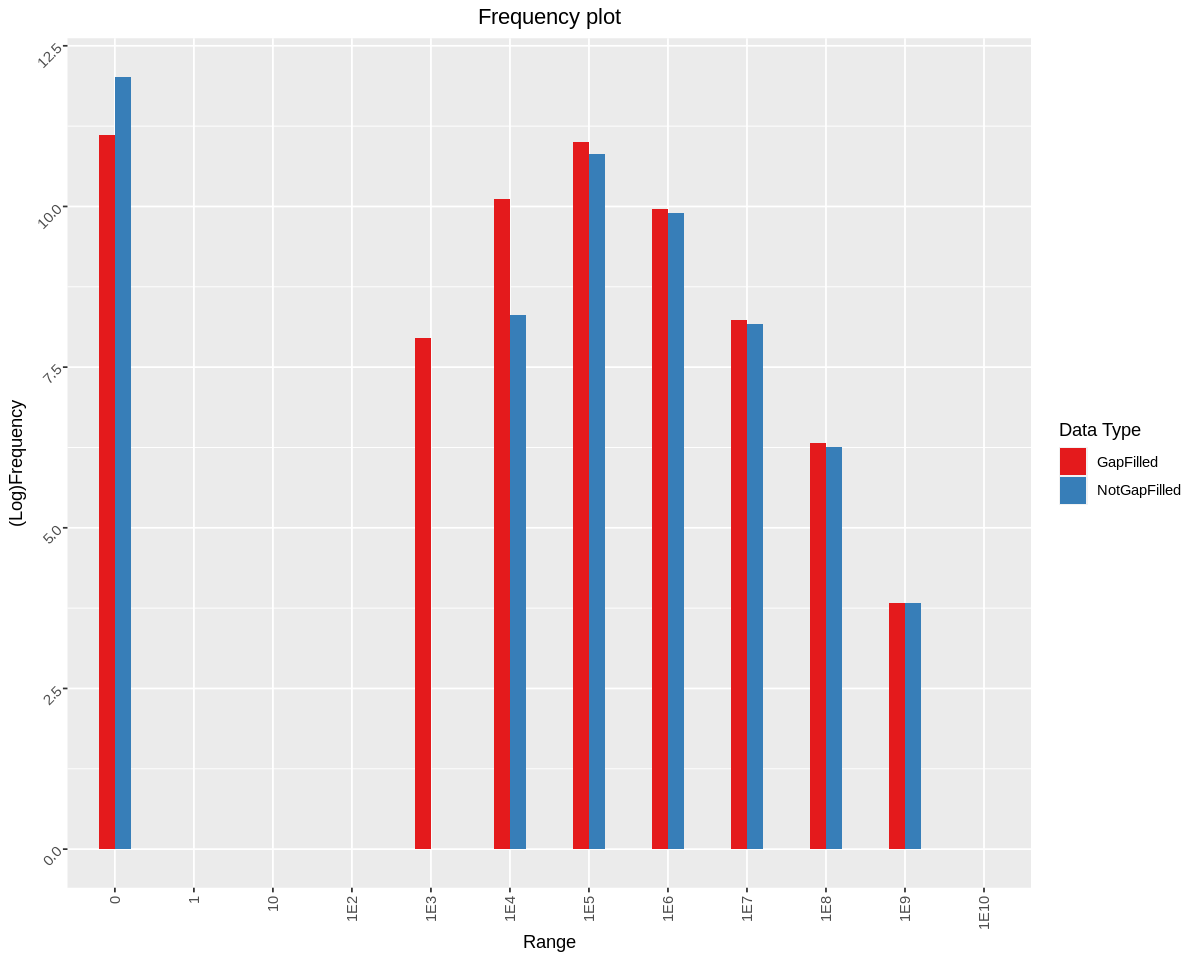

In [58]:
if(readline('Do you want to perform Imputation with minimum value of NonGapFilled table? - Y/N:')=='Y'){
    
    plot<- FrequencyPlot(GapFilled,NotGapFilled)
    
    Arg1 = plot$data$Condition[1]
    Arg2 = plot$data$Condition[13]
    
    # accessing the datatable of plot and subsetting with the condition: Eliminating the Range (or bin) 0 and Ranges with zero frequencies 
    plotData_New <- subset(plot$data,plot$data$Freq!=0 & plot$data$Range_bins !=0) 
    
    #getting the first appearing value of this new plot datatable
    First_val_temp <- aggregate(plotData_New$Freq, by=list(plotData_New$Condition), FUN=first) 
    
    # Subsetting the rows in the plotData_New that has the first appearing values
    First_val <- plotData_New[plotData_New$Freq %in% c(First_val_temp$x[1],First_val_temp$x[2]),]
  
    # getting the 2nd minimum value of non-gap filled data. (The first minimum value in the data table is usually zero)
    RawLOD <- round(min(NotGapFilled[NotGapFilled!=min(NotGapFilled)]))
    print(paste0("The minimum value greater than 0 for ",Arg1,":", round(min(GapFilled[GapFilled!=min(GapFilled)]))))
    print(paste0("The minimum value greater than 0 for ",Arg2,":", RawLOD))
    
    Imputed <- GapFilled
    Imputed[Imputed<RawLOD] <- RawLOD # Replacing values<RawLOD with RawLOD
} else return(GapFilled)

In [59]:
getwd()

[1] "/content"

In [61]:
write.csv(Imputed, file='data_results/Quant_Table_filled_with_MinValue.csv', row.names =TRUE) 

In [47]:
head(Imputed)
dim(Imputed)

,t2_BS_C.mzML,t0_BS_C.mzML,t1_BS_C.mzML,t5_BS_C.mzML,t3_BS_3.mzML,t2_BS_2.mzML,t3_BS_C.mzML,t2_BS_1.mzML,t3_BS_2.mzML,t1_BS_1.mzML,⋯,t5_BS_3.mzML,t6_BS_2.mzML,t5_BS_1.mzML,t6_BS_3.mzML,t0_BS_1.mzML,t9_BS_1.mzML,t5_BS_2.mzML,t8_BS_3.mzML,t9_BS_3.mzML,t9_BS_2.mzML
46_284.049_0.292,28967.65,6016.644,19891.79,137709.25,38654.650,123643.766,48592.70,87621.97,15638.634,43170.520,⋯,140709.11,57526.60,30458.35,3766.00,35278.086,69360.08,46725.547,69138.67,41619.816,158943.36
95_245.095_0.52,3766.00,3766.000,3766.00,43263.97,68092.710,54846.290,51597.93,40212.03,68410.980,74559.234,⋯,19731.48,63450.43,15515.95,73982.30,173294.600,34425.60,45211.176,30443.56,34075.530,51332.15
99_157.097_0.52,3766.00,3766.000,3766.00,4953.36,8625.011,4815.979,4152.35,3766.00,7641.581,6916.565,⋯,3766.00,14335.19,3766.00,16845.83,8836.821,15117.90,6946.169,10768.89,14589.145,31121.90
106_166.103_0.532,3766.00,3766.000,3766.00,3766.00,3766.000,3766.000,3766.00,3766.00,3766.000,3766.000,⋯,3766.00,3766.00,3766.00,3766.00,3766.000,3766.00,3766.000,3766.00,7789.463,11774.10
107_160.076_0.522,3766.00,3766.000,3766.00,354050.30,427649.620,312332.620,313545.00,209269.45,593663.900,401620.970,⋯,242058.36,954094.75,213120.95,814353.56,404429.660,931383.94,427234.220,666837.30,1050392.200,1309049.90
111_169.097_0.525,3766.00,4054.369,3766.00,637458.60,706535.700,609720.940,615655.20,468750.70,706034.300,665166.500,⋯,436133.40,893395.44,378563.44,886614.50,800889.440,890976.94,687120.800,804205.44,986138.440,1347099.20


[1] 4496   40

## Normalization:
The following code performs sample-centric (column-wise) normalisation:

In [96]:
if (readline("Do you want to perform Normalization: Y/N:") == 'Y'){
    
    #Getting column-wise sums of the input-data
    sample_sum <- colSums(Imputed, na.rm= TRUE, dims = 1)
    
    #Dividing each element of a particular column with its column sum
    Normalized_data <- c()
    for (i in 1:ncol(Imputed)){
        x <- Imputed[,i] / sample_sum[i]
        Normalized_data <- cbind(Normalized_data, x)
    }
    colnames(Normalized_data) <- names(sample_sum)
    
} else return(Imputed)
  
print(paste('No.of NA values in Normalized data:',sum(is.na(Normalized_data)== TRUE)))

Do you want to perform Normalization: Y/N:Y
[1] "No.of NA values in Normalized data: 0"


In [99]:
write.csv(Normalized_data,file='data_results/Normalised_Quant_table.csv',row.names =TRUE) 

In the following cell, we are checking once again if the rownames of our metadata is the same as the column names of our feature table. It should return **TRUE** and we are also checking the data sparsity before proceeding into any statistical tests. Data sparsity tells the amount of zeros we have in our normalized dataframe.

In [100]:
#Making sure the metadata rownames are identical to that of filenames in our featuretable in order to perform multivariate statistics
md_Stats <- md[which(rownames(md)%in%colnames(Normalized_data)),]
md_Stats <- md_Stats[match(colnames(Normalized_data),rownames(md_Stats)),]
identical(colnames(Normalized_data),rownames(md_Stats))

#Checking the data sparsity (amount of zeros in our data matrix):
sum(Normalized_data == 0)/(dim(Normalized_data)[1]*dim(Normalized_data)[2])

[1] TRUE

[1] 0

In our case, there are no zeros as we have already imputed them all !! Let's do some statistics.

## Principal Coordinate analysis:

Principal coordinates analysis (PCoA) is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph ([Gower, 2005](https://doi.org/10.1002/0470011815.b2a13070)). Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). Selecting the best distance metric for a given dataset is part of the 'art' of data science.

Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted). 

Calculating the pairwise distances across all samples using the Bray-Curtis distance metric:

In [102]:
md_Stats <- md[which(rownames(md)%in%colnames(Normalized_data)),]
md_Stats <- md_Stats[match(colnames(Normalized_data),rownames(md_Stats)),]

dist_matrix <- bcdist(t(Normalized_data)) # transposed in order to compute the distance between the columns of a data matrix
pcoa<- cmdscale(dist_matrix, eig = TRUE, x.ret=TRUE)
pcoa.var.per <-round(pcoa$eig/sum(pcoa$eig)*100,1)
pcoa.values <- pcoa$points

Now that we have calculated our distance matrix, we can plot our PCoA analysis for any of the attributes in our metadata. Lets say, we choose the 2nd attribute "sample type" in the next cell, we can visualise the difference between the samples treated with and without antibiotics. 

     [,1]                  
[1,] "ATTRIBUTE_species"   
[2,] "ATTRIBUTE_SampleType"
[3,] "ATTRIBUTE_timepoint" 
[4,] "ATTRIBUTE_hours"     
[5,] "ATTRIBUTE_mins"      
[6,] "ATTRIBUTE_replicates"
Enter the index of your interested attribute for PCoA visualisation:2


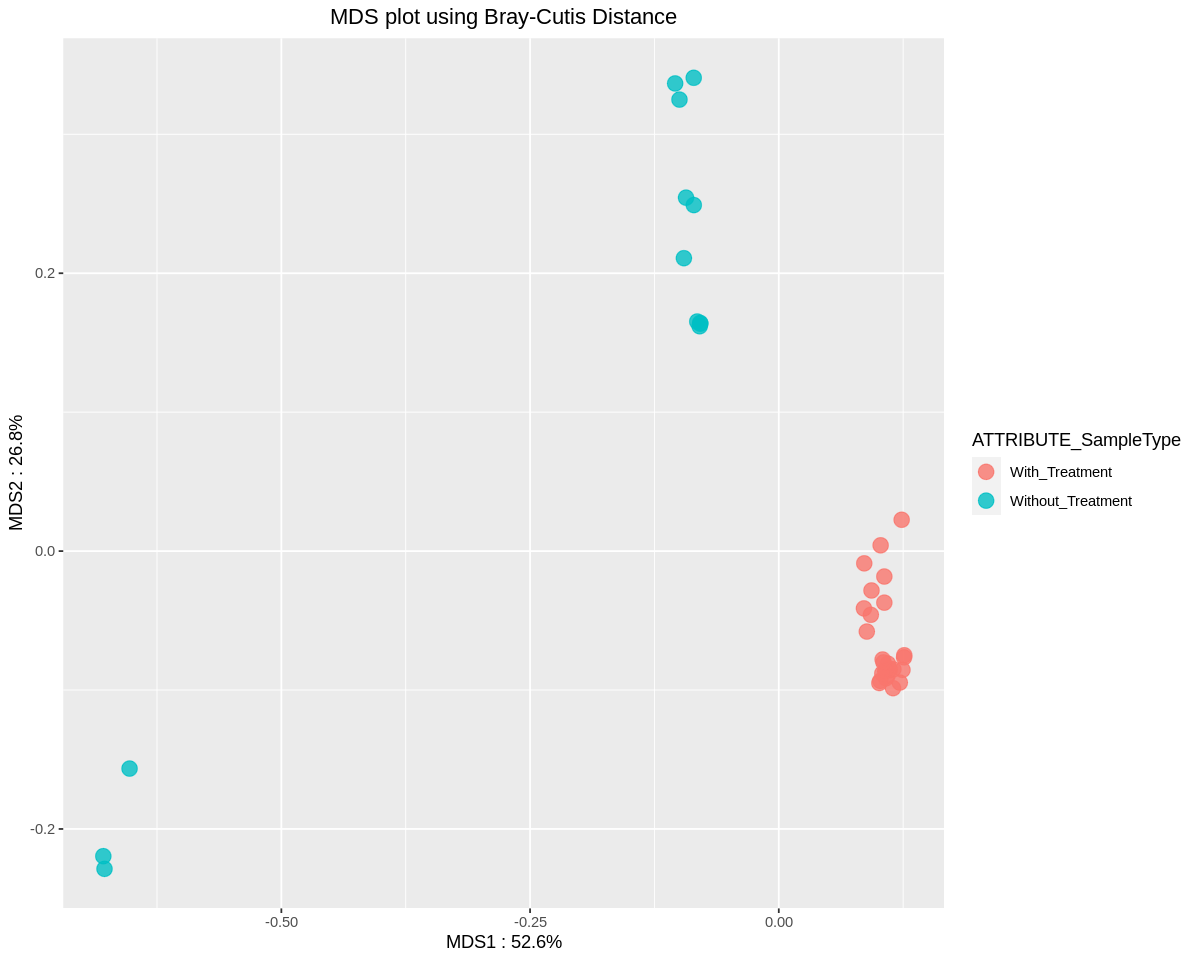

In [103]:
print(matrix(data=colnames(md_Stats),nrow=length(colnames(md_Stats))))
at_int <- as.double(readline('Enter the index of your interested attribute for PCoA visualisation:'))

flush.console()  
Sys.sleep(0.2)

#PCoA plot visualisation:
pcoa.data <- data.frame(md_Stats[,at_int],
                        X=pcoa.values[,1],
                        Y=pcoa.values[,2])

PCoA_plot <- ggplot(pcoa.data, aes(x=X, y=Y, col= as.factor(md_Stats[,at_int]))) + 
  geom_point(size=4,alpha=0.8)  +
  ggtitle(label="MDS plot using Bray-Cutis Distance") +
  xlab(paste0("MDS1 : ",pcoa.var.per[1],"%",sep="")) + 
  ylab(paste0("MDS2 : ",pcoa.var.per[2],"%",sep="")) + 
  labs(color = colnames(md_Stats)[at_int]) + 
  theme(plot.title = element_text(hjust = 0.5)) 

PCoA_plot

You can re-run the above cell with other attributes. But, when you try to visualise with attributes such as "Timepoint" or "hours", you cannot infer any trend. In such cases, we can subset our data and look at a particular condition.<br> Let us look at only the treated samples!!

In [105]:
md_Stats <- md[which(rownames(md)%in%colnames(Normalized_data)),]
md_Stats <- md_Stats[match(colnames(Normalized_data),rownames(md_Stats)),]

#Metadata subsetting based on condition:
print(matrix(data=colnames(md_Stats),nrow=length(colnames(md_Stats))))
Condition <- as.double(unlist(strsplit(readline("Enter the IDs of interested attributes separated by commas:"),split=",")))
for(i in 1:length(Condition)){
  #Shows the different levels within each selected condition:
  Levels_Cdtn <- levels(as.factor(md_Stats[,Condition[i]]))
  print(matrix(Levels_Cdtn,length(Levels_Cdtn)))
  
  #These lines are not needed in R console, but in Jupyter Notebook to get the previous print statement working
  flush.console()  
  Sys.sleep(0.2)
  
  #Among the shown levels of an attribute, select the ones to keep
  Cdtn <- as.double(unlist(strsplit(readline("Enter the IDs of condition(s) you want to KEEP (separated by commas):"), split=',')))
  Levels_Cdtn[Cdtn]
  
  #Selecting only rows in meta_filtered that match the condition
  md_Stats <- md_Stats[(md_Stats[,Condition[i]] == Levels_Cdtn[Cdtn]),]
}

     [,1]                  
[1,] "ATTRIBUTE_species"   
[2,] "ATTRIBUTE_SampleType"
[3,] "ATTRIBUTE_timepoint" 
[4,] "ATTRIBUTE_hours"     
[5,] "ATTRIBUTE_mins"      
[6,] "ATTRIBUTE_replicates"
Enter the IDs of interested attributes separated by commas:2
     [,1]               
[1,] "With_Treatment"   
[2,] "Without_Treatment"
Enter the IDs of condition(s) you want to KEEP (separated by commas):1,2


In [108]:
#PCoA calculation for the subset data
md_data <- Normalized_data[,which(colnames(Normalized_data)%in%rownames(md_Stats))] # the corresponding column files for the filtered metadata is picked from the normalized data

dist_matrix <- as.matrix(bcdist(t(md_data))) # transposed in order to compute the distance between the columns of a data matrix
pcoa<- cmdscale(dist_matrix, eig = TRUE, x.ret=TRUE)
pcoa.var.per <-round(pcoa$eig/sum(pcoa$eig)*100,1)
pcoa.values <- pcoa$points

Now you can try to visualise the plot for different attributes and see if you can infer something from the plot. (Spoiler alert: You do observe a trend with attributes: Timepoint, hours and mins)

     [,1]                  
[1,] "ATTRIBUTE_species"   
[2,] "ATTRIBUTE_SampleType"
[3,] "ATTRIBUTE_timepoint" 
[4,] "ATTRIBUTE_hours"     
[5,] "ATTRIBUTE_mins"      
[6,] "ATTRIBUTE_replicates"
Enter the index of your interested attribute for PCoA visualisation:3


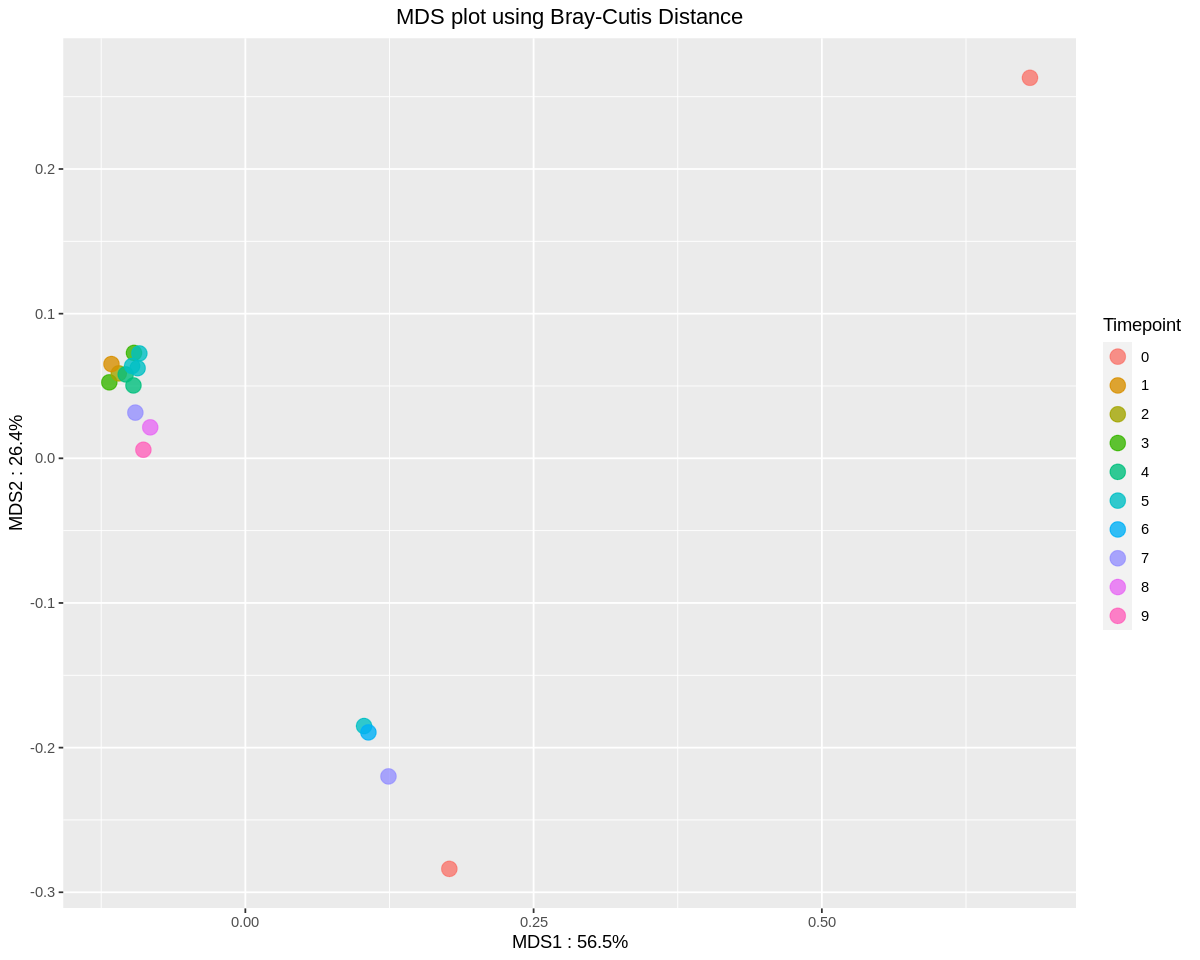

In [118]:
print(matrix(data=colnames(md_Stats),nrow=length(colnames(md_Stats))))
at_int <- as.double(readline('Enter the index of your interested attribute for PCoA visualisation:'))

flush.console()  
Sys.sleep(0.2)

#PCoA plot:
pcoa.data <- data.frame(md_Stats[,at_int],
                        X=pcoa.values[,1],
                        Y=pcoa.values[,2])

PCoA_plot <- ggplot(pcoa.data, aes(x=X, y=Y, col= as.factor(md_Stats[,at_int]))) + 
  geom_point(size=4,alpha=0.8)  +
  ggtitle(label="MDS plot using Bray-Cutis Distance") +
  xlab(paste0("MDS1 : ",pcoa.var.per[1],"%",sep="")) + 
  ylab(paste0("MDS2 : ",pcoa.var.per[2],"%",sep="")) + 
  labs(color = 'Timepoint') + 
  theme(plot.title = element_text(hjust = 0.5)) 

PCoA_plot

## Permutational multivariate analysis of variance (PERMANOVA):

PERMANOVA is a non-parametric method for multivariate analysis of variance, where P-values are obtained using permutations. The metric was originally developed within the field of ecology ([Anderson, 2008](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x)) but is today widely used in other fields, including the microbiome and metabolomics field. PERMANOVA is used to compare groups of samples and tests whether the centroid and/or the spread of the samples is different between the groups. 

The adonis2() function in the vegan package can be used to perform a PERMANOVA. The input is any dissimilarity matrix and the test-statistic retrieved is a multivariate analogue to Fisher's F-ratio as well as an R2 value (Adonis R2). Here, we have used the same distance matrix we calculated for our PCoA.

In [116]:
adonres <- adonis2(dist_matrix  ~ md_Stats[,at_int],permutations = 999, distance='bray')
rownames(adonres)[1] <- colnames(md_Stats)[at_int]
adonres

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATTRIBUTE_SampleType,1,0.5121123,0.4439617,11.97656,0.001
Residual,15,0.6413934,0.5560383,NA,NA
Total,16,1.1535057,1.0000000,NA,NA


The PERMANOVA test result tells us that, for P < 0.05, there is a significant difference amng the different conditions within the given attribute (significant variation expressed as the percentage of  Adonis R2).

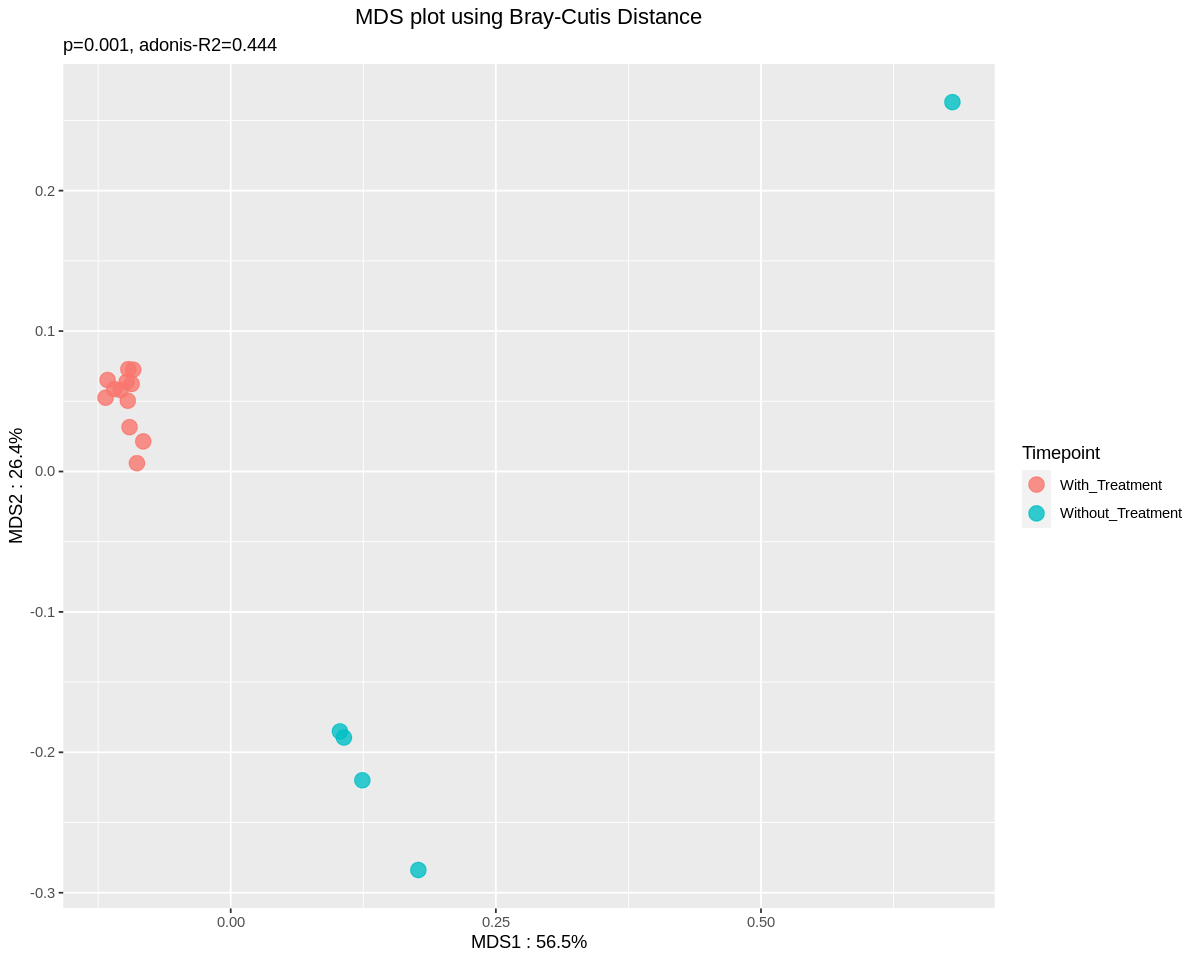

In [117]:
PCoA_plot + labs(subtitle = paste0("p=",round(adonres$'Pr(>F)'[1],4),', ' ,"adonis-R2=",round(adonres$'R2'[1],4)))

In [114]:
ggsave(PCoA_plot,filename="MDS_plot.svg", width = 10, height = 8)